# Book Recommender System of Tech Books

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [4]:
book_reviews = pd.read_csv('../data/tech_books.csv',
                            encoding='utf-8')
book_reviews.drop('Location', axis=1, inplace=True)
pd.options.display.float_format = '{:,.2f}'.format

## Sample of dataset

In [5]:
book_reviews.head()

,UserID,ISBN,Rating,Title,TotalRatings
0,276822,0805057706,10,The Number Devil: A Mathematical Adventure,4
1,27838,0805057706,9,The Number Devil: A Mathematical Adventure,4
2,276859,0789706032,8,The Complete Idiot's Guide to the Microsoft Ne...,1
3,277427,0811811409,10,The Venetian's Wife: A Strangely Sensual Tale ...,37
4,11676,0811811409,10,The Venetian's Wife: A Strangely Sensual Tale ...,37


## Top 5 Total Ratings per distinct books

In [6]:
top_total_ratings = book_reviews.nlargest(250, columns=['TotalRatings'])['Title'].unique()
book_reviews[book_reviews['Title'].isin(top_total_ratings)].drop_duplicates('Title')[['UserID', 'Title', 'TotalRatings']].reset_index(drop=True)

,UserID,Title,TotalRatings
0,277427,The Venetian's Wife: A Strangely Sensual Tale ...,37
1,278314,A Beautiful Mind: The Life of Mathematical Gen...,136
2,2358,Ringworld Engineers,37
3,6789,To Engineer Is Human: The Role of Failure in S...,13
4,16413,Innumeracy: Mathematical Illiteracy and Its Co...,13
5,20172,The Code Book: The Science of Secrecy from Anc...,11
6,71102,Fermat's Enigma: The Epic Quest to Solve the W...,11


<IPython.core.display.Javascript object>


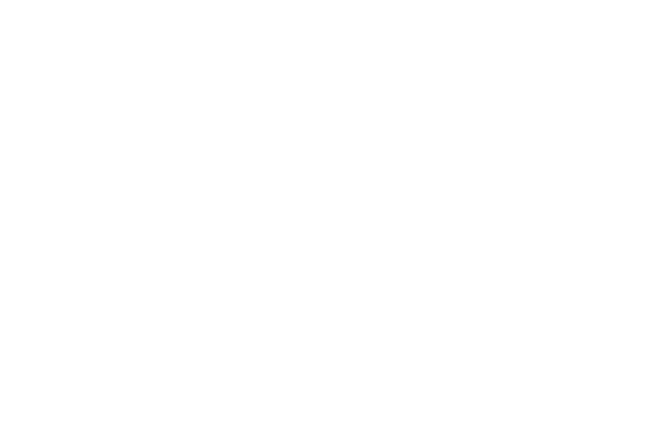

In [7]:
%matplotlib notebook

plt.figure(num=None, figsize=(9, 6), dpi=45)
book_reviews.TotalRatings.value_counts().plot(kind='bar')
plt.rc('font', size=25)
plt.title('Total Ratings Distribution')
plt.xlabel('Total Ratings')
plt.ylabel('Count')
plt.show()

## Top 5 books per Ratings

In [8]:
book_reviews.nlargest(20, columns=['Rating']).drop_duplicates('Title')[['UserID', 'Title', 'Rating']].reset_index(drop=True)

,UserID,Title,Rating
0,276822,The Number Devil: A Mathematical Adventure,10
1,277427,The Venetian's Wife: A Strangely Sensual Tale ...,10
2,36606,A Beautiful Mind: The Life of Mathematical Gen...,10
3,228595,Even Steven and Odd Todd (Hello Math Reader. L...,10
4,55548,Zen &amp; the Art of the Macintosh : Discoveri...,10


In [9]:
%matplotlib notebook

plt.figure(num=None, figsize=(9, 6), dpi=45)
book_reviews.Rating.value_counts().plot(kind='bar')
plt.rc('font', size=20)
plt.title('Ratings Distribution')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

<IPython.core.display.Javascript object>

## Descriptive statistics of Total Ratings

In [10]:
book_reviews['TotalRatings'].describe()

count   2,443.00
mean       10.90
std        31.03
min         1.00
25%         1.00
50%         1.00
75%         4.00
max       136.00
Name: TotalRatings, dtype: float64

In [11]:
book_title = "Rapid Development: Taming Wild Software Schedules"

In [12]:
books_rating_pivot = book_reviews.pivot(index='Title', columns='UserID', values='Rating').fillna(0)
books_rating_matrix = csr_matrix(books_rating_pivot.values)

book_list = list(books_rating_pivot.index)
finded_book = next((res for res in book_list if book_title in res), None)

In [13]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(books_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [14]:
book_index = books_rating_pivot.index == finded_book
x = books_rating_pivot.iloc[book_index, :].values.reshape(1, -1)
distances, idx = model_knn.kneighbors(x, n_neighbors=5)

## Results of Collaborative Filtering Using K-Nearest Neighbors

In [15]:
print('Recommendations for "\033[1m{0}"\033[0m book:\n'.format(books_rating_pivot[book_index].index[0].format()))

for i in range(len(distances.flatten())):
    print('\033[1m"{0}"\033[0m'.format(books_rating_pivot.index[idx.flatten()[i]],distances.flatten()[i]))

Recommendations for "Rapid Development: Taming Wild Software Schedules" book:

"Software Engineering: A Practitioner's Approach"
"E-Business: Roadmap for Success (Addison-Wesley Information Technology Series)"
"Rapid Development: Taming Wild Software Schedules"
"The New Direct Marketing: How to Implement a Profit-Driven Database Marketing Strategy"
"MCSE Windows NT Server 4.0 Study Guide (Exam 70-67)"


In [16]:
pca = PCA(n_components=8, random_state=42)
pca_matrix = pca.fit_transform(books_rating_pivot)
corr = np.corrcoef(pca_matrix)

## Results of Collaborative Filtering Using Matrix Factorization 

In [17]:
print('Recommendations for "\033[1m{0}"\033[0m book:\n'.format(finded_book))

if finded_book is not None:
    corr_result = corr[book_list.index(finded_book)]
    corr_result = corr_result[~np.isnan(corr_result)]
    max_indices = np.argsort(corr_result)[-10:]
    books_title = books_rating_pivot.index
    top_result = books_title[max_indices]
    
    for result, score in reversed(list(zip(top_result, corr_result[max_indices]))):
        print('\033[1m"{0}"\033[0m'.format(result, score))
else:
    print("There are not recommended books!!!")

Recommendations for "Rapid Development: Taming Wild Software Schedules" book:

"The Business of Ecommerce : From Corporate Strategy to Technology (Breakthroughs in Application Development)"
"Information Rules: A Strategic Guide to the Network Economy"
"Rapid Development: Taming Wild Software Schedules"
"E-Business: Roadmap for Success (Addison-Wesley Information Technology Series)"
"Practical UNIX Security (Computer security)"
"The New Direct Marketing: How to Implement a Profit-Driven Database Marketing Strategy"
"Software Engineering: A Practitioner's Approach"
"Real Estate Law (Prindle, Weber, and Schmidt Series in Mathematics)"
"MCSE Windows NT Server 4.0 in the Enterprise Study Guide (Exam 70-68)"
"MCSE Windows NT Server 4.0 Study Guide (Exam 70-67)"


In [18]:
df_1 = book_reviews.groupby('Title', as_index=False)['Rating'].mean()
df_2 = book_reviews.groupby('Title', as_index=False)['TotalRatings'].mean()
new_df = df_1.merge(df_2, on='Title')
new_df.head()

,Title,Rating,TotalRatings
0,"1,001 Computer Hints &amp; Tips: An A-To-Z Gui...",10.00,1
1,10 Minute Guide to Excel 97 (10 Minute Guides ...,0.00,1
2,100 Great Problems of Elementary Mathematics: ...,0.00,1
3,101 Things to Do With Your Computer (Usborne C...,0.00,1
4,101 Wacky Computer Jokes,1.40,5


In [19]:
mean_rating = new_df['Rating'].mean()

In [20]:
min_ratings = new_df['TotalRatings'].quantile(0.50)

In [21]:
books = new_df.copy().loc[new_df['TotalRatings'] >= min_ratings]

NameError: name 'm' is not defined

In [ ]:
def weighted_rating(x, m=min_ratings, C=mean_rating):
    v = x['TotalRatings']
    R = x['Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
books['score'] = books.apply(weighted_rating, axis=1)

In [ ]:
books = books.sort_values('score', ascending=False)

In [ ]:
books[['Title', 'Rating', 'TotalRatings', 'score']].head()

## Results of Content-Based Filtering 

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(stop_words='english', ngram_range=(3, 5), analyzer="char")

In [3]:
books = pd.read_csv('../data/books.csv', encoding='utf-8')
books['Title'] = books['Title'].fillna('')
books.reset_index(inplace=True)

In [4]:
book_vectors = tf_idf.fit_transform(books['Title'])

In [5]:
from sklearn.metrics.pairwise import linear_kernel

In [6]:
def get_recommendations(title):
    title_vector = tf_idf.transform([title.lower()])
    similarities = linear_kernel(title_vector, book_vectors).flatten() 
    recommendation_indices = np.argsort(-similarities)[:10]
    scores = similarities[recommendation_indices]
    recommended_books = books[['Title', 'Author']].iloc[recommendation_indices].values
    return scores, recommended_books

In [9]:
book = "Programming Python"

scores, recommendations = get_recommendations(book)
for [score, [book, author]] in zip(scores, recommendations):
    print('{score:.3f} | \033[1m"{book}"\033[0m, {author}'.format(score=score, book=book, author=author))

1.000 | "Programming Python", Mark Lutz
0.749 | "Programming Python (2nd Edition)", Mark Lutz
0.603 | "Introduction to Computation and Programming Using Python", John V. Guttag
0.559 | "Bioinformatics Programming Using Python: Practical Programming for Biological Data", Mitchell L. Model
0.550 | "Functional Python Programming", Steven Lott
0.527 | "Parallel Programming with Python", Jan Palach
0.522 | "Beginning Programming with Python For Dummies", John Paul Mueller
0.497 | "Python Web Programming", Steve  Holden
0.487 | "Learning Python (Help for Programmers)", Mark Lutz
0.478 | "Python Programming for Beginners: An Introduction to the Python Computer Language and Computer Programming", Jason Cannon
